### Explain Classifier
---------------------
Kilian Lüders & Bent Stohlmann

8.6.2023 (Submitted Version)

This notebook contains the code for the last section of the paper explaining the classifier using the LIME approach.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import xgboost as xgb

import matplotlib.pyplot as plt 

import rule_based_classification as rbc

from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [2]:
metadata = pd.read_csv("data/Metadaten2.6.1.csv", sep="\t")
metadata = metadata.rename(columns={'dateiname': 'entscheidung'}) # uniform variable naming
metadata = metadata[metadata['inAS'] == 1]
metadata["band"] = metadata["band"].astype(int)
metadata["ersteSeite"] = metadata["ersteSeite"].astype(int)
metadata["name_print"] = "BVerfGE " + metadata["band"].astype(str) + ", " + metadata["ersteSeite"].astype(str)
metadata.head()

,entscheidung,aktenzeichen,inAS,fundstelle,band,ersteSeite,letzteSeite,jahr,monat,tag,...,bvp,bvt,pbvs,pbvu,pbvv,vz,namenRichter,anzahlRichter,manuellErgaenzt,name_print
0,bs20010615_2bvb000101,2 BvB 1/01,1,"BVerfGE 104, 38-39",104,38,39.0,2001,6,15,...,False,False,False,False,False,False,"Limbach, Sommer, Jentsch, Hassemer, Broß, Oste...",7,0,"BVerfGE 104, 38"
1,bs20010615_2bvb000201,2 BvB 2/01,1,"BVerfGE 104, 39-40",104,39,40.0,2001,6,15,...,False,False,False,False,False,False,"Limbach, Sommer, Jentsch, Hassemer, Broß, Oste...",7,0,"BVerfGE 104, 39"
2,bs20010615_2bvb000301,2 BvB 3/01,1,"BVerfGE 104, 41-41",104,41,41.0,2001,6,15,...,False,False,False,False,False,False,"Limbach, Sommer, Jentsch, Hassemer, Broß, Oste...",7,0,"BVerfGE 104, 41"
3,bs20010703_2bvb000101,2 BvB 1/01;2 BvB 2/01;2 BvB 3/01;2 BvB 1/01;2 ...,1,"BVerfGE 104, 42-51",104,42,51.0,2001,7,3,...,False,False,False,False,False,False,"Limbach, Sommer, Jentsch, Hassemer, Broß, Oste...",8,0,"BVerfGE 104, 42"
4,bs20010703a_2bvb000101,2 BvB 1/01;2 BvB 2/01;2 BvB 3/01;2 BvB 1/01;2 ...,1,"BVerfGE 104, 42-51",104,42,51.0,2001,7,3,...,False,False,False,False,False,False,"Limbach, Sommer, Jentsch, Hassemer, Broß, Oste...",8,0,"BVerfGE 104, 42"


In [3]:
# list for resuluts
data_metrics = list()

# function to report results
def report_result(y_pre, y_tes, model_name, feature_name, info_txt, class_type = "sent", fold_num=np.nan, loss=np.nan):
    precision_ind, recall_ind, fscore_ind, scores = precision_recall_fscore_support(y_tes, y_pre, average=None)
    precision_micro, recall_micro, fscore_micro, scores_micro = precision_recall_fscore_support(y_tes, y_pre, average='micro')
    print("{} - {} - {} \t {} \t F1:\t{:.2f}".format(model_name,feature_name, info_txt, class_type, fscore_micro))
    tn, fp, fn, tp = confusion_matrix(y_tes, y_pre).ravel()
    result = {
        'model': model_name,
        'feature': feature_name,
        'info': info_txt,
        'type': class_type,
        'fold': fold_num,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'precision_ind_0' : precision_ind[0],
        'precision_ind_1' : precision_ind[1],
        'precision_micro': precision_micro,
        'recall_ind_0': recall_ind[0],
        'recall_ind_1': recall_ind[1],
        'recall_micro': recall_micro,
        'fscore_ind_0': fscore_ind[0],
        'fscore_ind_1': fscore_ind[1],
        'fscore_mirco': fscore_micro,
        'loss': loss
    }
    return result

In [4]:
# training data
training_data = pd.read_pickle("data/training_data.pkl")
training_data['len_prop'] = training_data.prop
training_data['prop'] = (training_data.prop > 0).astype('int')

In [5]:
training_data = training_data.merge(metadata[['entscheidung', 'name_print']], on="entscheidung", how="left")

In [6]:
data_y = training_data['prop']
data_X = np.zeros(len(data_y))

split_thing = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=565)
train_index, test_index = list(split_thing.split(data_X, data_y))[0]

y_train, y_test = data_y[train_index], data_y[test_index]

print("train n: {} \t with proportionality: {}".format(y_train.count(), y_train.sum()))
print("test n: {} \t with proportionality: {}".format(y_test.count(), y_test.sum()))

train n: 240 	 with proportionality: 48
test n: 60 	 with proportionality: 12


In [7]:
test_df = training_data.iloc[test_index,:]
test_df

,entscheidung,len,prop,text,X_lemma,X_token,X_we,len_prop,name_print
272,rs20000216_1bvr042097,91,0,B. Die Verfassungsbeschwerde ist zulässig. Die...,der verfassungsbeschwerde sein zulässig der b...,die verfassungsbeschwerde ist zulässig die be...,"[-0.016511852, -0.17145231, 0.02052589, 0.0064...",0,"BVerfGE 102, 26"
67,"BVerfGE25,309",23,0,B. Die Verfassungsbeschwerde ist unbegründet. ...,der verfassungsbeschwerde sein unbegründet de...,die verfassungsbeschwerde ist unbegründet die...,"[0.0073922174, -0.18334615, -0.046585012, 0.05...",0,"BVerfGE 25, 309"
160,"BVerfGE64,208",38,0,B. Die Verfassungsbeschwerde ist zulässig. Der...,der verfassungsbeschwerde sein zulässig der r...,die verfassungsbeschwerde ist zulässig der re...,"[0.017581336, -0.18396506, -0.016184632, 0.046...",0,"BVerfGE 64, 208"
124,"BVerfGE47,327",628,1,B. Die Verfassungsbeschwerden sind im wesentli...,der verfassungsbeschwerde sein in wesentliche...,die verfassungsbeschwerden sind im wesentlich...,"[0.013531363, -0.1623489, 0.003450281, 0.02370...",43,"BVerfGE 47, 327"
221,"BVerfGE88,017",21,0,II. 1. Die Besorgnis der Befangenheit eines Ri...,der besorgnis der befangenheit ein richter de...,die besorgnis der befangenheit eines richters...,"[-0.000801007, -0.16196632, 0.006041058, 0.036...",0,"BVerfGE 88, 17"
274,rs20010320_1bvr049196,151,1,B. Die Verfassungsbeschwerde ist im Wesentlich...,der verfassungsbeschwerde sein in wesentliche...,die verfassungsbeschwerde ist im wesentlichen...,"[0.03281414, -0.1939882, -0.016033126, -0.0077...",106,"BVerfGE 103, 172"
130,"BVerfGE51,060",82,0,B. Die Vorlage ist zulässig. Das vorlegende Ge...,der vorlage sein zulässig der vorlegend geric...,die vorlage ist zulässig das vorlegende geric...,"[0.045416784, -0.19818226, 0.015101245, 0.0234...",0,"BVerfGE 51, 60"
203,"BVerfGE81,275",13,0,B. Die Vorlage ist unzulässig. 1. Das Verfahre...,der vorlage sein unzulässig der verfahren der...,die vorlage ist unzulässig das verfahren der ...,"[0.036420092, -0.22301339, 0.06901857, 0.04723...",0,"BVerfGE 81, 275"
144,"BVerfGE57,043",166,0,B. Die form- und fristgerecht eingelegte Verfa...,der und fristgerecht eingelegt verfassungsbes...,die und fristgerecht eingelegte verfassungsbe...,"[-0.068999894, -0.18845466, 0.0053131497, 0.06...",0,"BVerfGE 57, 43"
163,"BVerfGE66,260",20,0,B. Die zulässige Verfassungsbeschwerde ist beg...,der zulässig verfassungsbeschwerde sein begrü...,die zulässige verfassungsbeschwerde ist begrü...,"[0.041404177, -0.20520464, 0.013324499, 0.0496...",0,"BVerfGE 66, 260"


## Rule based approach

In [8]:
y_predict_rb = training_data.iloc[test_index,:].apply(lambda row: rbc.check_entscheidung(row.entscheidung, row.text), axis=1).apply(lambda x: int(x))

test_df['predict_rb'] = y_predict_rb

data_metrics.append(report_result(y_predict_rb, y_test, "rule based", "", "", "dec"))

rule based -  -  	 dec 	 F1:	0.93


## XGBoost Lemma tfidf

In [9]:
data_X = training_data['X_lemma']
x_train, x_test = data_X[train_index], data_X[test_index]

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(x_train)
x_test = tfidf.transform(x_test)

xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train, y_train)

y_predict_xgb = xgb_cl.predict(x_test)
test_df['predict_xgb'] = y_predict_xgb

data_metrics.append(report_result(y_predict_xgb, y_test, "XGBoost", "tfidf", "lemma", "dec", ""))

XGBoost - tfidf - lemma 	 dec 	 F1:	0.93


In [10]:
metrics_df =pd.DataFrame(data=data_metrics)
metrics_df

,model,feature,info,type,fold,tn,fp,fn,tp,precision_ind_0,precision_ind_1,precision_micro,recall_ind_0,recall_ind_1,recall_micro,fscore_ind_0,fscore_ind_1,fscore_mirco,loss
0,rule based,,,dec,NaN,45,3,1,11,0.978261,0.785714,0.933333,0.937500,0.916667,0.933333,0.957447,0.846154,0.933333,NaN
1,XGBoost,tfidf,lemma,dec,,47,1,3,9,0.940000,0.900000,0.933333,0.979167,0.750000,0.933333,0.959184,0.818182,0.933333,NaN


In [11]:
metrics_df.to_csv("fig/tab_2.csv")
metrics_df[['model', 'tn', 'fp', 'fn', 'tp', 'fscore_ind_1', 'fscore_mirco',]].style.to_latex("fig/tab_2.tex")

## Confusion

In [12]:
def confusion_fun(tar, pred):
    if tar == 1:
        if pred == 1:
            return "tp"
        else:
            return "fn"
    else:
        if pred == 0:
            return "tn"
        else:
            return "fp"
        
test_df['conf_rb'] = test_df.apply(lambda row: confusion_fun(row.prop, row.predict_rb), axis=1)
test_df['conf_xgb'] = test_df.apply(lambda row: confusion_fun(row.prop, row.predict_xgb), axis=1)

print("Rule based:")
print(test_df.conf_rb.value_counts())
print("XGBoost:")
print(test_df.conf_xgb.value_counts())

Rule based:
tn    45
tp    11
fp     3
fn     1
Name: conf_rb, dtype: int64
XGBoost:
tn    47
tp     9
fn     3
fp     1
Name: conf_xgb, dtype: int64


In [13]:
test_df.groupby(['conf_rb','conf_xgb']).size()

conf_rb  conf_xgb
fn       fn           1
fp       tn           3
tn       fp           1
         tn          44
tp       fn           2
         tp           9
dtype: int64

In [14]:
test_df[test_df.predict_rb != test_df.predict_xgb]

,entscheidung,len,prop,text,X_lemma,X_token,X_we,len_prop,name_print,predict_rb,predict_xgb,conf_rb,conf_xgb
272,rs20000216_1bvr042097,91,0,B. Die Verfassungsbeschwerde ist zulässig. Die...,der verfassungsbeschwerde sein zulässig der b...,die verfassungsbeschwerde ist zulässig die be...,"[-0.016511852, -0.17145231, 0.02052589, 0.0064...",0,"BVerfGE 102, 26",0,1,tn,fp
130,"BVerfGE51,060",82,0,B. Die Vorlage ist zulässig. Das vorlegende Ge...,der vorlage sein zulässig der vorlegend geric...,die vorlage ist zulässig das vorlegende geric...,"[0.045416784, -0.19818226, 0.015101245, 0.0234...",0,"BVerfGE 51, 60",1,0,fp,tn
142,"BVerfGE57,009",69,1,B.-I. Entscheidungsgegenstand des Verfassungsb...,entscheidungsgegenstand der verfassungsbeschw...,entscheidungsgegenstand des verfassungsbeschw...,"[0.013976714, -0.18746261, 0.010489375, 0.1023...",3,"BVerfGE 57, 9",1,0,tp,fn
265,ls20140401_2bvl000209,80,0,B. Die Vorlage ist unzulässig. Sie genügt nich...,der vorlage sein unzulässig sie genügen nicht...,die vorlage ist unzulässig sie genügt nicht d...,"[0.014566176, -0.18530095, 0.013866471, 0.0309...",0,"BVerfGE 136, 127",1,0,fp,tn
290,rs20120508_1bvr106503,109,0,B. Die Verfassungsbeschwerden sind unzulässig....,der verfassungsbeschwerde sein unzulässig so...,die verfassungsbeschwerden sind unzulässig s...,"[0.035401136, -0.19998133, -0.008934368, 0.046...",0,"BVerfGE 131, 66",1,0,fp,tn
254,fs20150721_1bvf000213,186,1,B. Der nach Art. 93 Abs. 1 Nr. 2 und Nr. 2a GG...,der nach art und gg und bverfgg zulässig norm...,der nach art und gg und bverfgg zulässige nor...,"[-0.016824603, -0.1924813, 0.027356626, 0.0414...",35,"BVerfGE 140, 65",1,0,tp,fn


## Explain Classifier

In [15]:
ml_pipe = make_pipeline(tfidf, xgb_cl)

explainer = LimeTextExplainer(class_names=test_df.prop)

### Explain TP

In [16]:
tp_df = test_df[(test_df.conf_rb == 'tp') & (test_df.conf_xgb  == 'tp')].sample(n=4, random_state=1837)
tp_df

,entscheidung,len,prop,text,X_lemma,X_token,X_we,len_prop,name_print,predict_rb,predict_xgb,conf_rb,conf_xgb
124,"BVerfGE47,327",628,1,B. Die Verfassungsbeschwerden sind im wesentli...,der verfassungsbeschwerde sein in wesentliche...,die verfassungsbeschwerden sind im wesentlich...,"[0.013531363, -0.1623489, 0.003450281, 0.02370...",43,"BVerfGE 47, 327",1,1,tp,tp
267,ls20170329_2bvl000611,222,1,B. Die Vorlage ist zulässig. I. Sie bedarf all...,der vorlage sein zulässig sie bedürfen aller...,die vorlage ist zulässig sie bedarf allerdin...,"[-0.02212931, -0.18682034, -0.05878081, 0.0258...",3,"BVerfGE 145, 106",1,1,tp,tp
156,"BVerfGE63,343",216,1,B.-I. Die Verfassungsbeschwerde ist zulässig. ...,der verfassungsbeschwerde sein zulässig sie g...,die verfassungsbeschwerde ist zulässig sie gr...,"[-0.0050135683, -0.18951401, 0.02138005, 0.077...",2,"BVerfGE 63, 343",1,1,tp,tp
274,rs20010320_1bvr049196,151,1,B. Die Verfassungsbeschwerde ist im Wesentlich...,der verfassungsbeschwerde sein in wesentliche...,die verfassungsbeschwerde ist im wesentlichen...,"[0.03281414, -0.1939882, -0.016033126, -0.0077...",106,"BVerfGE 103, 172",1,1,tp,tp


#### Explain TP XGBoost

In [17]:
exp_plot_data = list()

for idx in range(4):
    print('Entscheidung: ' + tp_df.iloc[idx,8])
    exp = explainer.explain_instance(tp_df.iloc[idx,4], ml_pipe.predict_proba)
    print(tp_df.iloc[idx,4])
    print('Prediction =', ml_pipe.predict([tp_df.iloc[idx,4]]))
    print('True class: %s' % tp_df.iloc[idx,2])
    exp_plot_data.append((tp_df.iloc[idx,8], exp.as_list()))


Entscheidung: BVerfGE 47, 327
 der verfassungsbeschwerde sein in wesentliche zulässig zu verfassungsrechtlich prüfung stehen in erster linie der von der beschwerdeführer bezeichnet einzelregelung der beschwerdeführer zu bis beantragen zwar der aufhebung der gesamt universitätsgesetz und der beschwerdeführer zu und außerdem der aufhebung der hochschulgesetz aus der begründung ihr verfassungsbeschwerde ergeben sich jedoch daß sie einzeln regelung der genannt gesetz beanstanden und nur aus der verfassungswidrigkeit der einzeln bezeichnet vorschrift der nichtigkeit beide gesetz insgesamt herleiten auch bei der zulässigkeitsprüfung sein daher von der angegriffen einzelregelung ausgehen der verfassungsbeschwerde sein mit folgend ausnahme rechtzeitig erheben -- verspätet sein der rüge der beschwerdeführer zu und soweit dieser in ein bei bundesverfassungsgericht an dezember eingegangen nachtrag zu verfassungsbeschwerde erstmals beanstanden daß der universitätspräsident gemäß satz hg dienstvorg

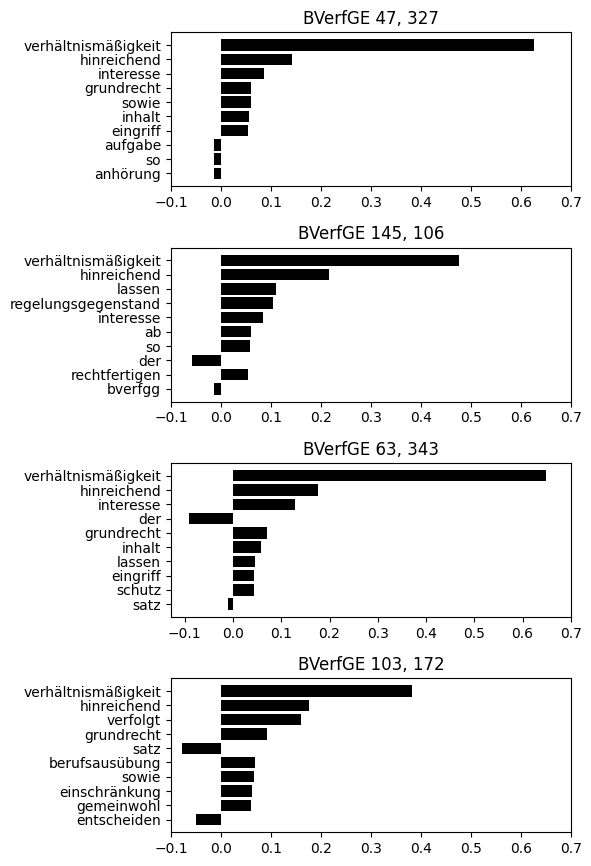

In [18]:
fig, ax = plt.subplots(4, 1, figsize=(5,10))
plt.tight_layout(pad=0.8)


for i, c in enumerate(exp_plot_data):
    words = [e[0] for e in c[1]]
    values = [e[1] for e in c[1]]
    ax[i].barh(words, values, color="black")
    ax[i].invert_yaxis()
    ax[i].set_title(c[0])
    ax[i].set_xticks(np.linspace(-0.1,0.7, num=9))

plt.subplots_adjust(left=0.1,
                bottom=0.1,
                right=0.9,
                top=0.9,
                wspace=0.4,
                hspace=0.4)

plt.show()

#### Explain TP RBC

In [19]:
def rbc_decision(row):
    output = False
    if not row['is_konjunktiv']: # kein Konjunktiv
        if row['relevant_vhmk']: # Fall vhmk Relevant:
            if not row['is_vhmk_adjd'] and not row['is_vhmk_erschwert']: # Weder adjd Verwendung noch 'unvhmk erschwert'
                output = True
        if row['relevant_stufen']: # Fall stufen relevant
            if row['is_erfge_adja']:
                if row['is_erfge_adja_mittel']: # wenn erf./ge. als Adjektiv, dann prüfen, ob "Mittel"/"Maß" die Nomen
                    output = True
            else:
                output = True
        if row['relevant_uebermass']: # Fall übermassverbot relevant
            output = True
    return output

In [20]:
idx = 0
print(tp_df.iloc[idx,0])
rbc_df = rbc.check_entscheidung(tp_df.iloc[idx,0], tp_df.iloc[idx,3], return_df=True)[1]
rbc_df['output'] = rbc_df.apply(lambda row: rbc_decision(row), axis=1)
for x in rbc_df[rbc_df.output == True].text_raw:
    print(x)

BVerfGE47,327
Dabei muß die Abwägung den Wertprinzipien der Verfassung, insbesondere der Bedeutung der miteinander kollidierenden Grundrechte, und dem rechtsstaatlichen Grundsatz der Verhältnismäßigkeit unter Wahrung der Einheit des Grundgesetzes Rechnung tragen.
Nach Inkrafttreten des § 6 HUG wurden weiterhin Bedenken laut, die sich vor allem gegen die mangelnde Bestimmtheit, die Unverhältnismäßigkeit, die Erstreckung der Informationspflicht auch auf den Bereich außerhalb der Hochschulen und die Verpflichtung zur öffentlichen Information richteten (vgl. Kupfer, Informationsverpflichtung für Wissenschaftler?, WissR, Bd. 4, 1971, S. 117).
Außerdem werden die gegen die Erforderlichkeit und Verhältnismäßigkeit des Grundrechtseingriffs erhobenen Bedenken ausgeräumt.
Leben und Gesundheit sind so hochwertige verfassungsrechtlich geschützte Rechtsgüter, daß grundsätzlich keine Bedenken bestehen, die freie wissenschaftliche Betätigung der Beschwerdeführer in dem hier gegebenen Rahmen zu begren

In [21]:
idx = 1
print(tp_df.iloc[idx,0])
rbc_df = rbc.check_entscheidung(tp_df.iloc[idx,0], tp_df.iloc[idx,3], return_df=True)[1]
rbc_df['output'] = rbc_df.apply(lambda row: rbc_decision(row), axis=1)
for x in rbc_df[rbc_df.output == True].text_raw:
    print(x)

ls20170329_2bvl000611
Dabei ergeben sich je nach Regelungsgegenstand und Differenzierungsmerkmalen aus dem allgemeinen Gleichheitssatz im Sinne eines stufenlosen am Grundsatz der Verhältnismäßigkeit orientierten Prüfungsmaßstabs unterschiedliche Grenzen für den Gesetzgeber, die vom bloßen Willkürverbot bis zu einer strengen Bindung an Verhältnismäßigkeitserfordernisse reichen (stRspr;
Offenbleiben kann ferner, ob hier Gründe für eine eher strenge Verhältnismäßigkeitsprüfung der gesetzgeberischen Differenzierung zwischen Kapitalgesellschaften mit schädlichem Beteiligungserwerb und ohne einen solchen vorliegen (s. oben Rn. 105).


In [22]:
idx = 2
print(tp_df.iloc[idx,0])
rbc_df = rbc.check_entscheidung(tp_df.iloc[idx,0], tp_df.iloc[idx,3], return_df=True)[1]
rbc_df['output'] = rbc_df.apply(lambda row: rbc_decision(row), axis=1)
for x in rbc_df[rbc_df.output == True].text_raw:
    print(x)

BVerfGE63,343
Zwar ist im Bereich der Steuergesetze anders als bei den meisten sonstigen Eingriffsermächtigungen eine Verbindung zwischen Eingriffszweck und Eingriffsgewicht im Einzelfall nicht herzustellen und deshalb auch eine konkrete Verhältnismäßigkeitsprüfung im Sinne einer Abwägung der jeweiligen Interessen in der Tat nicht möglich.


In [23]:
idx = 3
print(tp_df.iloc[idx,0])
rbc_df = rbc.check_entscheidung(tp_df.iloc[idx,0], tp_df.iloc[idx,3], return_df=True)[1]
rbc_df['output'] = rbc_df.apply(lambda row: rbc_decision(row), axis=1)
for x in rbc_df[rbc_df.output == True].text_raw:
    print(x)

rs20010320_1bvr049196
Eine einzelne Maßnahme ist zur Erreichung des gesetzgeberischen Zwecks auch nicht deshalb unverhältnismäßig, weil nicht alle Betroffenen durch die gesetzlichen Vorkehrungen gleichmäßig belastet werden.
Die Altersgrenze wahrt auch den Grundsatz der Verhältnismäßigkeit im engeren Sinne.
Sie ist insbesondere deshalb verhältnismäßig, weil sie den Zulassungsgremien abweichende Entscheidungen ermöglicht, wenn dies zur Vermeidung von unbilligen Härten erforderlich ist.
1. Aus dem allgemeinen Gleichheitssatz ergeben sich je nach Regelungsgegenstand und Differenzierungsmerkmalen unterschiedliche Grenzen für den Gesetzgeber, die vom bloßen Willkürverbot bis zu einer strengen Bindung an Verhältnismäßigkeitserfordernisse reichen.


## Explain FP

#### FP XGBoost Pred

In [24]:
fp_df = test_df[test_df.conf_xgb == "fp"]
fp_df

,entscheidung,len,prop,text,X_lemma,X_token,X_we,len_prop,name_print,predict_rb,predict_xgb,conf_rb,conf_xgb
272,rs20000216_1bvr042097,91,0,B. Die Verfassungsbeschwerde ist zulässig. Die...,der verfassungsbeschwerde sein zulässig der b...,die verfassungsbeschwerde ist zulässig die be...,"[-0.016511852, -0.17145231, 0.02052589, 0.0064...",0,"BVerfGE 102, 26",0,1,tn,fp


Entscheidung: rs20000216_1bvr042097
 der verfassungsbeschwerde sein zulässig der beschwerdeführer werden durch der strafbewehrt verbot gegenwärtig und unmittelbar betreffen bis zu erlass der verordnung sein sie befugen der für der behandlung ihr patient erforderlich zelltherapeutika herstellen sie benötigen weder ein herstellungserlaubnis nach der arzneimittelgesetz noch sein der präparat selbst zulassungspflichtig nach dieser gesetz der beschwerdeführer sein dieser für sie ganz wesentlich teil der beruflich betätigung nehmen werden ohne dass es ein vollzugsakt bedürfen gegen der geltend gemacht grundrechtsverletzung können der beschwerdeführer auch nicht anderweit rechtsschutz vor der fachgerichter erhalten unter der gesichtspunkt der subsidiarität der verfassungsbeschwerde kommen ein verweisung auf ein solcher rechtsschutz zwar in betracht wenn er in tatsächlich und rechtlich hinsicht geeignet sein der unmittelbar normwirkung ein gerichtlich prüfung zu unterziehen der der anforderung

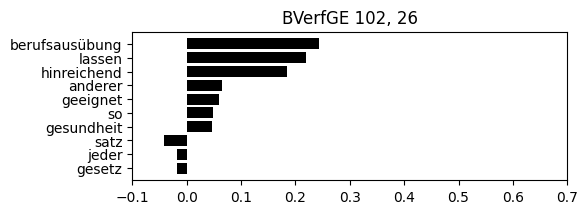

In [25]:

idx = 0

print('Entscheidung: ' + fp_df.iloc[idx,0])
exp = explainer.explain_instance(fp_df.iloc[idx,4], ml_pipe.predict_proba)
print(fp_df.iloc[idx,4])
print('Prediction =', ml_pipe.predict([fp_df.iloc[idx,4]]))
print('True class: %s' % fp_df.iloc[idx,2])
c = (fp_df.iloc[idx,8], exp.as_list())

fig, ax = plt.subplots(1, 1, figsize=(5,2))
plt.tight_layout(pad=0.8)


words = [e[0] for e in c[1]]
values = [e[1] for e in c[1]]
ax.barh(words, values, color="black")
ax.invert_yaxis()
ax.set_title(c[0])
ax.set_xticks(np.linspace(-0.1,0.7, num=9))

plt.show()


#### FP RB Explain

In [26]:
exp.as_list()

[('berufsausübung', 0.24362864475192247),
 ('lassen', 0.21988605911912956),
 ('hinreichend', 0.1849024423586902),
 ('anderer', 0.06516827683846514),
 ('geeignet', 0.06019168377894418),
 ('so', 0.04800589185201003),
 ('gesundheit', 0.046845498730794154),
 ('satz', -0.04107804493559119),
 ('jeder', -0.017684249137639222),
 ('gesetz', -0.0175205129744272)]

In [27]:
fp_df = test_df[test_df.conf_rb == "fp"]
fp_df

,entscheidung,len,prop,text,X_lemma,X_token,X_we,len_prop,name_print,predict_rb,predict_xgb,conf_rb,conf_xgb
130,"BVerfGE51,060",82,0,B. Die Vorlage ist zulässig. Das vorlegende Ge...,der vorlage sein zulässig der vorlegend geric...,die vorlage ist zulässig das vorlegende geric...,"[0.045416784, -0.19818226, 0.015101245, 0.0234...",0,"BVerfGE 51, 60",1,0,fp,tn
265,ls20140401_2bvl000209,80,0,B. Die Vorlage ist unzulässig. Sie genügt nich...,der vorlage sein unzulässig sie genügen nicht...,die vorlage ist unzulässig sie genügt nicht d...,"[0.014566176, -0.18530095, 0.013866471, 0.0309...",0,"BVerfGE 136, 127",1,0,fp,tn
290,rs20120508_1bvr106503,109,0,B. Die Verfassungsbeschwerden sind unzulässig....,der verfassungsbeschwerde sein unzulässig so...,die verfassungsbeschwerden sind unzulässig s...,"[0.035401136, -0.19998133, -0.008934368, 0.046...",0,"BVerfGE 131, 66",1,0,fp,tn


In [28]:
idx = 0
print(fp_df.iloc[idx,0])
rbc_df = rbc.check_entscheidung(fp_df.iloc[idx,0], fp_df.iloc[idx,3], return_df=True)[1]
rbc_df['output'] = rbc_df.apply(lambda row: rbc_decision(row), axis=1)
for x in rbc_df[rbc_df.output == True].text_raw:
    print(x)

BVerfGE51,060
Eine derartige Annahme läßt sich weder aus dem Übermaßverbot noch aus dem Gleichheitssatz oder sonstigem Verfassungsrecht herleiten.
Wenn der Gesetzgeber unter diesen Umständen das Führen des Fahrzeugs ohne die erforderliche Fahrerlaubnis unter Strafe stellt, so ist dies weder willkürlich, noch begegnet es unter dem Gesichtspunkt des Übermaßverbotes Bedenken.


In [29]:
idx = 1
print(fp_df.iloc[idx,0])
rbc_df = rbc.check_entscheidung(fp_df.iloc[idx,0], fp_df.iloc[idx,3], return_df=True)[1]
rbc_df['output'] = rbc_df.apply(lambda row: rbc_decision(row), axis=1)
for x in rbc_df[rbc_df.output == True].text_raw:
    print(x)

ls20140401_2bvl000209
Im Ergänzungsbeschluss geht der Bundesfinanzhof von den vom Bundesverfassungsgericht in den Beschlüssen vom 7. Juli 2010 (BVerfGE 127, 1 [18]; 127, 31 [48]; 127, 61 [77]) entwickelten Rechtsgrundsätzen aus, nach denen eine unechte Rückwirkung mit den Grundsätzen des grundrechtlichen und rechtsstaatlichen Vertrauensschutzes nur vereinbar ist, wenn sie zur Förderung des Gesetzeszwecks geeignet und erforderlich ist und wenn bei einer Gesamtabwägung zwischen dem Gewicht des enttäuschten Vertrauens und dem Gewicht und der Dringlichkeit der die Rechtsänderung rechtfertigenden Gründe die Grenze des Zumutbaren gewahrt bleibt.


In [30]:
idx = 2
print(fp_df.iloc[idx,0])
rbc_df = rbc.check_entscheidung(fp_df.iloc[idx,0], fp_df.iloc[idx,3], return_df=True)[1]
rbc_df['output'] = rbc_df.apply(lambda row: rbc_decision(row), axis=1)
for x in rbc_df[rbc_df.output == True].text_raw:
    print(x)

rs20120508_1bvr106503
Auslagen für Alternativberechnungen sind den Beschwerdeführern zumutbar, wenn die Erhebung einer Verfassungsbeschwerde dadurch nicht in unverhältnismäßiger Weise erschwert wird.


### Explain FN

#### Explain FN XGB

In [31]:
fn_df = test_df[test_df.conf_xgb == "fn"]
fn_df

,entscheidung,len,prop,text,X_lemma,X_token,X_we,len_prop,name_print,predict_rb,predict_xgb,conf_rb,conf_xgb
143,"BVerfGE57,029",49,1,II. Die zulässige Verfassungsbeschwerde ist un...,der zulässig verfassungsbeschwerde sein unbeg...,die zulässige verfassungsbeschwerde ist unbeg...,"[0.034810275, -0.20351076, 0.017694077, 0.0977...",4,"BVerfGE 57, 29",0,0,fn,fn
142,"BVerfGE57,009",69,1,B.-I. Entscheidungsgegenstand des Verfassungsb...,entscheidungsgegenstand der verfassungsbeschw...,entscheidungsgegenstand des verfassungsbeschw...,"[0.013976714, -0.18746261, 0.010489375, 0.1023...",3,"BVerfGE 57, 9",1,0,tp,fn
254,fs20150721_1bvf000213,186,1,B. Der nach Art. 93 Abs. 1 Nr. 2 und Nr. 2a GG...,der nach art und gg und bverfgg zulässig norm...,der nach art und gg und bverfgg zulässige nor...,"[-0.016824603, -0.1924813, 0.027356626, 0.0414...",35,"BVerfGE 140, 65",1,0,tp,fn


In [32]:
idx = 2
print(fn_df.iloc[idx,0])
rbc_df = rbc.check_entscheidung(fn_df.iloc[idx,0], fn_df.iloc[idx,3], return_df=True)[1]
rbc_df['output'] = rbc_df.apply(lambda row: rbc_decision(row), axis=1)
for x in rbc_df[rbc_df.output == True].text_raw:
    print(x)

fs20150721_1bvf000213
Es ist dafür auch weder geeignet noch erforderlich.


In [33]:
idx = 1
print(fn_df.iloc[idx,0])
rbc_df = rbc.check_entscheidung(fn_df.iloc[idx,0], fn_df.iloc[idx,3], return_df=True)[1]
rbc_df['output'] = rbc_df.apply(lambda row: rbc_decision(row), axis=1)
for x in rbc_df[rbc_df.output == True].text_raw:
    print(x)

BVerfGE57,009
Die Entscheidungen der Gerichte hierüber werden im Verfahren der Verfassungsbeschwerde vom Bundesverfassungsgericht nur darauf überprüft, ob dabei gegen Grundrechte oder grundrechtsähnliche Rechte des Beschwerdeführers verstoßen worden ist, ob der angewendeten Norm ein verfassungswidriger Sinn beigelegt und dadurch die Einwirkung von Bundesverfassungsrecht auf die Feststellung, Auslegung und Anwendung einfachen Rechts grundsätzlich verkannt worden ist, ob die Auslegung und Anwendung des einfachen Rechts willkürlich ist, gegen das verfassungsrechtliche Übermaßverbot verstößt oder ob eine verfassungsrechtlich gebotene Rechtsgüterabwägung entweder nicht oder offensichtlich fehlerhaft vorgenommen worden ist.
Verstöße gegen das Willkürverbot des Art. 3 Abs. 1 GG, gegen den Verfassungsgrundsatz des Übermaßverbots oder gegen ein Gebot verfassungsrechtlicher Rechtsgüterabwägung scheiden bei dem entscheidungserheblichen Sachverhalt als mögliche Rechtsverletzung im Sinne des Art. 1

In [34]:
fp_df = test_df[test_df.conf_rb == "fn"]
fp_df

,entscheidung,len,prop,text,X_lemma,X_token,X_we,len_prop,name_print,predict_rb,predict_xgb,conf_rb,conf_xgb
143,"BVerfGE57,029",49,1,II. Die zulässige Verfassungsbeschwerde ist un...,der zulässig verfassungsbeschwerde sein unbeg...,die zulässige verfassungsbeschwerde ist unbeg...,"[0.034810275, -0.20351076, 0.017694077, 0.0977...",4,"BVerfGE 57, 29",0,0,fn,fn
